*Andrew Calderwood*

In [46]:
import os
from os.path import basename, dirname
import sys

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
from scipy.optimize import minimize

from datetime import datetime
from datetime import timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# from pandas.tseries import converter

In [2]:

## Set up directory referencing
# Package data
git_dir = dirname(dirname(os.getcwd()))
git_dir = os.getcwd()
while basename(git_dir) != 'CosumnesRiverRecharge':
    git_dir = dirname(git_dir)
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel


In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
tprogs_id = '_no_conditioning'

data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [4]:
fxn_dir = git_dir+'/python_utilities'
if fxn_dir not in sys.path:
    sys.path.append(fxn_dir)
# sys.path
# import muskingum_recharge as mr

from importlib import reload
# reload(mr)

In [5]:
nrow= 100
ncol =230

In [6]:
# dem data for cropping above land surface
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_linear.tsv')

# No flow routing, recharge loss only

In [7]:
Q_cfs = 22500 # 5 year
# Q_cfs = 2000 # 1ish year

Q_cms = Q_cfs*(0.3048**3) # convert to cubic meters per second


In [8]:
from muskingum_recharge import min_Q, mannings, calc_depth_arr


In [9]:
setbacks = np.arange(0, 3400,200)
# smoothed XS data used for setback analysis
xs_levee_smooth = pd.read_csv(chan_dir+'xs_levee_smooth.csv', index_col='dist_from_right_m')

# wse_grid.to_file(gis_dir+'wse_grid.shp')


In [106]:
# load array identifying row,col to setback ID (1,17)
str_setbacks = np.loadtxt(chan_dir+ 'regional_str_setback_id_arr.tsv', delimiter='\t').astype(int)
# str_setbacks = ma.masked_where(str_setbacks==0,str_setbacks)
str_setbacks = np.where(str_setbacks==0,np.NaN, str_setbacks)

In [10]:
# load array identifying row,col to XS id (1,28)
xs_arr = np.loadtxt(chan_dir+'XS_num_grid_reference.tsv')

In [97]:
soil_thick=2
fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth.tsv'

soil_K_out = np.loadtxt(fn, delimiter='\t')
soil_K = np.reshape(soil_K_out, (100, nrow, ncol))

# convert soil conductivity from m/d to m/s and apply vertical anisotropy factor
vani = 100
soil_K = soil_K/86400/vani 

In [12]:
flow_percentile=95
hf_tot_in =  np.loadtxt(data_dir+'surface_highflow_by_realization_'+str(flow_percentile)+'.tsv',delimiter = '\t')
hf_tot = np.reshape(hf_tot_in, (100, nrow, ncol))

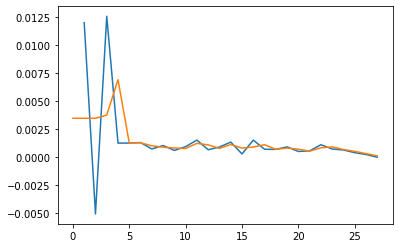

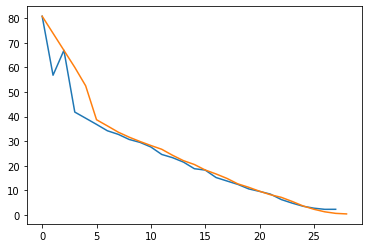

In [14]:
# find minimum from channel center
xs_mins = xs_levee_smooth.loc[3100:3300].min(axis=0)
xs_mins.index = xs_mins.index.astype(int)
# xs_mins.interpolate(method='linear').plot()
slope = xs_mins.diff().rolling(2, center=True, closed='right').mean().bfill()/2000*-1
adj_xs_mins = np.append(xs_mins[0], (xs_mins[0]-slope.cumsum()*2000))

(xs_mins.diff()/-2000).plot()
slope.plot()
plt.show()
xs_mins.plot()
plt.plot(adj_xs_mins)

# Flow loss procedure
1. Allocate arrays for:  
    1. flow (n realizations, n setbacks, n segments +1)  
    2. depth (n setbacks, nrow, ncol)  
    3. water surface elevation (n setbacks, nrow, ncol)  
    4. recharge (n realizations, n setbacks, nrow, ncol)  
2. Primary iteration:  
    1. Given a cross-section with a specified width for a given setback  
    2. Calculate the depth in the channel from the flow with Manning Equation  
    3. Add depth to cross-section minimum elevation to calculate water surface elevation for the given setback and segment  
3. Secondary Iteration:  
    1. Given a segment identify which cells have a water surface elevation above ground surface (i.e., inundated)  
    2. Calculate recharge based on inundated area, hydraulic gradient due to flood depth and vertical conductivity  
    3. Sum of recharge by segment  
    4. Calculate flow leaving the segment by subtracting recharge from flow entering the segment  
4. Optional Iteration:
    1. Apply a sequence of flows that include the rising limb and falling limb in addition to the peak flow
    2. Calculate total recharge from this continuous event
5. Outermost Iteration:  
    Complete these depth, recharge, flow calculations for each subsurface realization  
    

In [257]:
from scipy.optimize import minimize_scalar

# depths = np.zeros((len(setbacks), xs_levee_smooth.shape[1]))
Q = np.zeros((100, len(setbacks), xs_levee_smooth.shape[1]+1))
Q[:,:,0] = Q_cms
# save depth arrays for each setbacks
d_arr = np.zeros((len(setbacks), nrow, ncol))
wse_arr = np.zeros((len(setbacks), nrow, ncol))
# save high recharge flows
rch_hf_arr = np.zeros((100, len(setbacks), nrow, ncol))




Rather than focusing on improving the solver iteration which isn't that bad (21 iterations isn't great but it could be worse), I should work on solution: updating roughness based on cross-section width, include levee wall roughness in wetted perimeter. Look at sensitivity of vertical conductivity. Summarize recharge by time period of flood (travel time is 13.2 hours/45 km per Whipple, about 0.3 hrs per 1 km) which is about 0.6 hrs per 2km to multiply by the recharge rate.   
The current set up with a flow minus recharge makes sense if we assume a temporary steady state is reached (true for sub half hour), but if I want to start calculating volumes for transient events then I need to account for the duration.

In [297]:
Q[t, s,nseg], Q_cms, n, slope.iloc[nseg]

(637.1290483200002, 637.1290483200002, 'regional', 0.0034599012500000016)

In [334]:
t=0
n= 0.048
# iterate across all cross-sections
tic = time()
for nseg in np.arange(0,xs_levee_smooth.shape[1]):
    # iterate across all setbacks
    for s,setback in enumerate(setbacks):
        # for a given setback imagine there is an impenetrable levee blocking overbank flow
        xs_elevs = xs_levee_smooth.iloc[:,nseg][3100-setback:3300+setback]
        # solve for depth that matches given flow
        if Q[t, s,nseg] >0:
            d0 = [d_arr[s-1,(xs_arr==nseg)].max()]
            res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q[t, s,nseg]), 
                                  bounds=(0.1,10), method='bounded', tol=1E-3) 
            depth = res.x #[0]
        else:
            depth = 0
        # join depth calculated at cross-section to corresponding model cells and corresponding setback
        wse_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth + xs_elevs.min()
        d_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth 
    # identify wse above surface elevation 
    d_arr = d_arr* (wse_arr > dem_data)
    # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
    # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
    rch_hf_arr[t,:,:,:] = (xs_arr==nseg)*(soil_K[t,:,:])*hf_tot[t,:,:] *(200*200)*((d_arr* + soil_thick)/soil_thick)
    Q[t, :, nseg+1] = Q[t, :, nseg] - np.nansum(rch_hf_arr[t,:], axis=(1,2))
toc = time()
print(np.round(toc-tic,2))
# tol from 1E-5 to 1E-3 saves 10 seconds per realization (28 to 19)
# fancier minimizers don't help because of weird problem set up with highly nonlinear XS area

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\scipy\optimize\_minimize.py:784: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


19.91


It looks like not all of the high flow cells are coarse, so it may be worth going to 99th percentile or adjusting analysis. May be worth checking connectivity tools.

In [380]:
# temp = (hf_tot[0]==1) * (soil_K[t,:,:]>1E-6)
# plt.imshow(temp)
# plt.colorbar()
# plt.show()

# plt.imshow(hf_tot[t,:,:])
# plt.colorbar()

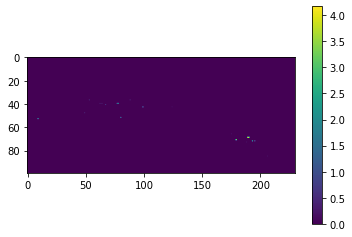

In [427]:
temp = (xs_arr>=0)*(soil_K[t,:,:])*hf_tot[t,:,:] *(200*200)*((d_arr* + soil_thick)/soil_thick)
# temp = (soil_K[t,:,:])*hf_tot[t,:,:] *(200*200)*((d_arr* + soil_thick)/soil_thick)
# temp = hf_tot[t,:,:]*soil_K[t,:,:]
plt.imshow(temp[-1,:,:],
#            norm= mpl.colors.LogNorm()
          )
plt.colorbar()
plt.show()

In [433]:
(rch_xs_sum.iloc[-1,:]!=0).sum()

69

In [258]:
from time import time
# takes ~45 minutes
# t=0
tic = time()
n = 0.048 # assume constant roughness for now

for t in np.arange(0,100):
    # iterate across all cross-sections
    for nseg in np.arange(0,xs_levee_smooth.shape[1]):
        # iterate across all setbacks
        for s,setback in enumerate(setbacks):
            # for a given setback imagine there is an impenetrable levee blocking overbank flow
            xs_elevs = xs_levee_smooth.iloc[:,nseg][3100-setback:3300+setback]
            # solve for depth that matches given flow
            if Q[t, s,nseg] >0:
                res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q[t, s,nseg]), bounds=(0,10), method='bounded')
                depth = res.x
            else:
                depth = 0
            # join depth calculated at cross-section to corresponding model cells and corresponding setback
            wse_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth + xs_elevs.min()
            d_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth 
        # identify wse above surface elevation 
        d_arr = d_arr* (wse_arr > dem_data)
        # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
        # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
        rch_hf_arr[t,:,:,:] = (xs_arr==nseg)*(soil_K[t,:,:])*hf_tot[t,:,:] *(200*200)*((d_arr* + soil_thick)/soil_thick)
        Q[t, :, nseg+1] = Q[t, :, nseg] - np.nansum(rch_hf_arr[t,:], axis=(1,2))
        
toc = time()
print((toc-tic)/3600)

0.002654661732196808


In [281]:
# rch_hf_arr


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.000000,0.753448,0.0,0.000000,0.0,0.0,0.478735,2.854852,0.000000,...,0.372030,0.000000,0.000000,0.956490,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
200,0.0,0.000000,1.448373,0.0,0.000000,0.0,0.0,0.583180,3.413996,0.000000,...,0.222770,0.000000,0.000000,1.435771,0.000000,0.000000,0.0,0.288269,0.000000,3.706244
400,0.0,0.000000,1.143541,0.0,0.000000,0.0,0.0,0.469151,2.811231,0.014897,...,0.176767,0.005951,0.000000,2.051935,0.000000,0.000000,0.0,0.228655,0.000000,2.940364
600,0.0,0.000000,1.423955,0.0,0.000000,0.0,0.0,4.007487,5.195140,0.025974,...,0.333582,0.007428,1.710196,2.840268,0.000000,0.274605,0.0,1.079199,0.000000,3.682551
800,0.0,2.469517,1.280018,0.0,1.489704,0.0,0.0,5.116792,4.654978,0.023287,...,0.299071,0.006687,3.076710,2.552201,0.821177,4.385102,0.0,2.506278,0.000000,3.316844
1000,0.0,2.307154,1.195812,0.0,1.390127,0.0,0.0,6.179872,4.338818,0.021625,...,0.279012,0.006233,2.872556,2.387942,0.765858,3.827042,0.0,0.905397,0.000000,3.076754
1200,0.0,2.204120,1.141882,0.0,1.318533,0.0,0.0,5.863676,4.062207,0.020604,...,0.265721,0.005965,2.742475,2.285977,0.729896,3.317806,0.0,2.231091,0.000000,2.931730
1400,0.0,2.176168,1.124123,0.0,1.314482,0.0,0.0,5.745635,4.006937,0.020244,...,0.260496,0.005872,2.698292,2.251868,0.718203,9.782747,0.0,2.190959,0.000000,2.889740
1600,0.0,2.191182,1.134310,0.0,1.336503,0.0,0.0,5.798552,4.037962,0.020449,...,0.262522,0.005924,2.721928,2.268128,0.720218,9.874396,0.0,2.210070,3.548202,2.920413
1800,0.0,2.165387,1.122531,0.0,1.327210,0.0,0.0,5.721636,3.991652,0.020202,...,0.259126,0.005856,2.690379,2.240759,0.706517,9.755218,0.0,2.182864,3.507555,2.875423


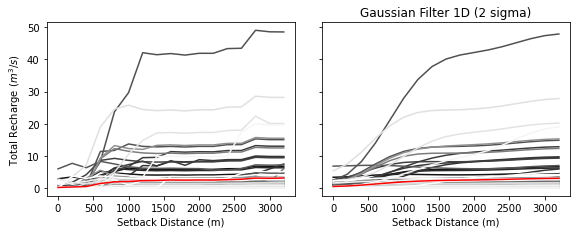

In [399]:
fig, axes = plt.subplots(1,2, figsize=(8,3), sharey=True)
fig.tight_layout()
rch_xs_sum = pd.DataFrame(np.sum(rch_hf_arr, axis=(2,3)), columns= setbacks).transpose()
rch_xs_sum.plot(legend=False, cmap='gray', ax =axes[0])
rch_xs_sum.mean(axis=1).plot(color='red', ax=axes[0])


axes[0].set_xlabel('Setback Distance (m)')
axes[0].set_ylabel('Total Recharge ($m^3/s$)')

# 1d so the smoothing is specific to each realization
from scipy.ndimage import gaussian_filter1d
# smooth across setback distances so the changes in high flow area are less abrupt, makes it easier to find gradients
smooth = gaussian_filter1d(rch_xs_sum,2, axis=0)

smooth = pd.DataFrame(smooth, index= setbacks)
smooth.plot(legend=False, cmap='gray', ax=axes[1], label='Realizations')
smooth.mean(axis=1).plot(color='red', ax=axes[1], label='Mean')

axes[1].set_title('Gaussian Filter 1D (2 sigma)')

axes[1].set_xlabel('Setback Distance (m)')

# axes[1].legend()
# tranpose to fit format for gradient analysis used previously
smooth = smooth.transpose()


Text(0, 0.5, 'Realizations with a maximum gradient')

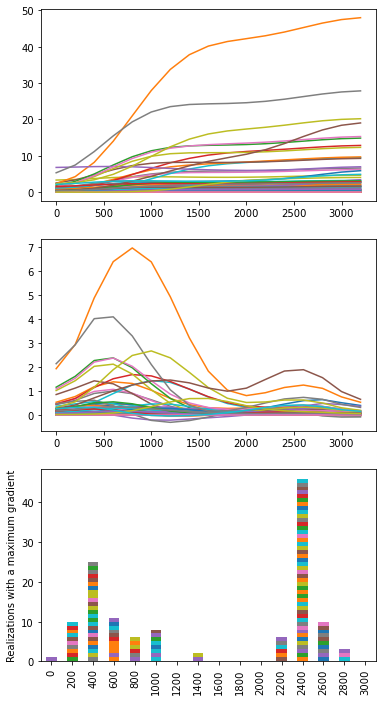

In [262]:
n='regional'
r = np.arange(0,100)
# can look at maximum of first derivative, or look where second derivative goes from + to -
grad1_df = pd.DataFrame(np.gradient(smooth)[1],  columns = setbacks)
# plt_hf_cum_area(grad1_df.loc[n].loc[r], percentile, n)

grad2_df = pd.DataFrame(np.gradient(grad1_df)[1],  columns = setbacks)
# # grad2_df
# plt_hf_cum_area(grad2_df.loc[n], percentile, n)
# find switching points
plt.show()
fig,ax=plt.subplots(3,1,figsize=(6,12), sharex=False)
smooth.loc[r].transpose().plot(legend=False,ax=ax[0]) #.loc[n]
plt.ylabel('High K area smoothed with setbacks')

grad1_df.loc[r].transpose().plot(legend=False,ax=ax[1]) #.loc[n]
plt.ylabel('First derivative of High K area')

# plt.legend(ncol=5,loc=(1.2,0.2))
# np.sign gives + or -, np diff gives out[i] = a[i+1] - a[i]. 
# + to - means max of 1st derivative. So diff ==-2 means max, but to account for difference go up one indice
max_df = pd.DataFrame(np.diff(np.sign(grad2_df)), columns = setbacks[:-1])
max_df = 1*(max_df==-2)
max_df.loc[r].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax[2]) #.loc[n]
plt.ylabel('Realizations with a maximum gradient')

Too much seepage loss, HK values are most likely too large, need to apply some vertical anistropy factor because I'm guessing a thin soil thickness. Initially with 2m soil thickness and standard HK field, seepage overcame streamflow. Attempting 4m with standard HK field to look at change. Fixed by applying anisotropy factor.

637.1290483200002


Text(0, 0.5, 'Discharge ($m^3/s$)')

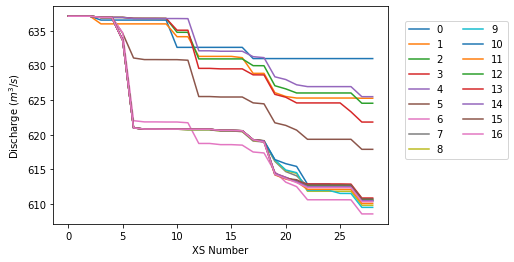

In [197]:
t=0
print(Q_cms)
pd.DataFrame(Q[t,:]).transpose().plot()
plt.legend(ncol=2, loc= (1.05,0.3))
plt.xlabel('XS Number')
plt.ylabel('Discharge ($m^3/s$)')

637.1290483200002


Text(0, 0.5, 'Discharge ($m^3/s$)')

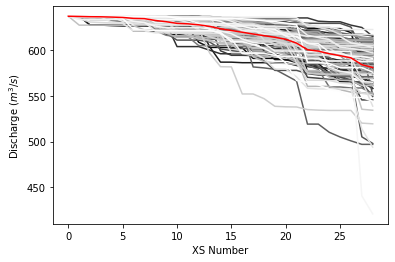

In [401]:
t=0
print(Q_cms)
Q_plt = pd.DataFrame(Q[:,-1,:]).transpose()
Q_plt.plot(cmap='gray', legend=False)
Q_plt.mean(axis=1).plot(color='red')
plt.xlabel('XS Number')
plt.ylabel('Discharge ($m^3/s$)')

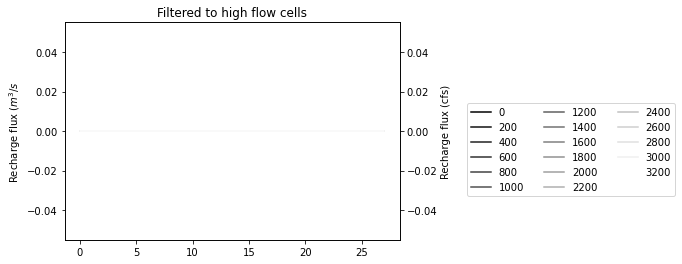

In [267]:
def plot_xs_sum(arr):
    # group recharge into upstream segments of each XS
    xs_sum = np.zeros((xs_levee_smooth.shape[1],len(setbacks)))
    for xs_n in np.arange(0,xs_levee_smooth.shape[1]):
        xs_sum[xs_n,:] = np.nansum(arr[:,xs_arr==xs_n], axis=1)
    # convert to dataframe for easier plotting
    xs_rch_df = pd.DataFrame(xs_sum,columns = setbacks)
    # plotting 
    fig, ax = plt.subplots()
    # xs_rch_df.plot(cmap='gray',  kind='bar', legend=True)
    xs_rch_df.plot(cmap='gray',  legend=False, ax=ax)
    plt.ylabel('Recharge flux ($m^3/s$')
    ax2 = ax.twinx()
    xs_rch_df.multiply((1/( 0.3048**3))).plot(cmap='gray', legend=False, ax=ax2)
    plt.ylabel('Recharge flux (cfs)')
    plt.legend(ncol=3, loc=(1.2,0.2))
    plt.xlabel('Cross section')
    plt.title('Filtered to high flow cells')
#testing
t=0
plot_xs_sum(rch_hf_arr[t,:])


In [402]:

def arr_2_df(arr):
    ''' Take array (realizations, setbacks, nrow, ncol)'''
    # group recharge into upstream segments of each XS
    xs_sum = np.zeros((100, xs_levee_smooth.shape[1],len(setbacks)))
    for xs_n in np.arange(0,xs_levee_smooth.shape[1]):
        xs_sum[:, xs_n,:] = np.nansum(arr[:, :, xs_arr==xs_n], axis=2)
    # convert to long dataframe for seaborn plotting
    xs_sum_long = np.reshape(xs_sum, (100*xs_levee_smooth.shape[1],len(setbacks)))
    xs_sum_long = pd.DataFrame(xs_sum_long,columns = setbacks)
    xs_sum_long['r'] = np.repeat(np.arange(0,100), xs_levee_smooth.shape[1])
    xs_sum_long['nseg'] = np.tile(np.arange(0,xs_levee_smooth.shape[1]), 100)
    xs_sum_long = xs_sum_long.melt(id_vars=['r','nseg'], var_name='XS', value_name='rch_m_s')
    return(xs_sum_long)
xs_sum_long = arr_2_df(rch_hf_arr)

In [422]:
arr = np.copy(rch_hf_arr)

# group recharge into upstream segments of each XS
xs_sum = np.zeros((100, xs_levee_smooth.shape[1],len(setbacks)))
for xs_n in np.arange(0,xs_levee_smooth.shape[1]):
    xs_sum[:, xs_n,:] = np.nansum(arr[:, :, xs_arr==xs_n], axis=2)
# convert to long dataframe for seaborn plotting
xs_sum_long = np.reshape(xs_sum, (100*xs_levee_smooth.shape[1],len(setbacks)))
xs_sum_long = pd.DataFrame(xs_sum_long,columns = setbacks)

In [425]:
xs_sum[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [420]:
# np.unique(xs_arr)
# plt.imshow(xs_arr)
# plt.colorbar()
# np.nansum(arr[:,xs_arr==xs_n], axis=1)
arr[:,:,xs_arr==xs_n]
# arr.shape

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [421]:
xs_sum_long
rch_hf_arr
arr = np.copy(rch_hf_arr)
# group recharge into upstream segments of each XS
xs_sum = np.zeros((xs_levee_smooth.shape[1],len(setbacks)))
for xs_n in np.arange(0,xs_levee_smooth.shape[1]):
    xs_sum[xs_n,:] = np.nansum(arr[:,:,xs_arr==xs_n], axis=1)
# convert to dataframe for easier plotting
xs_rch_df = pd.DataFrame(xs_sum,columns = setbacks)

ValueError: could not broadcast input array from shape (100,147) into shape (17,)

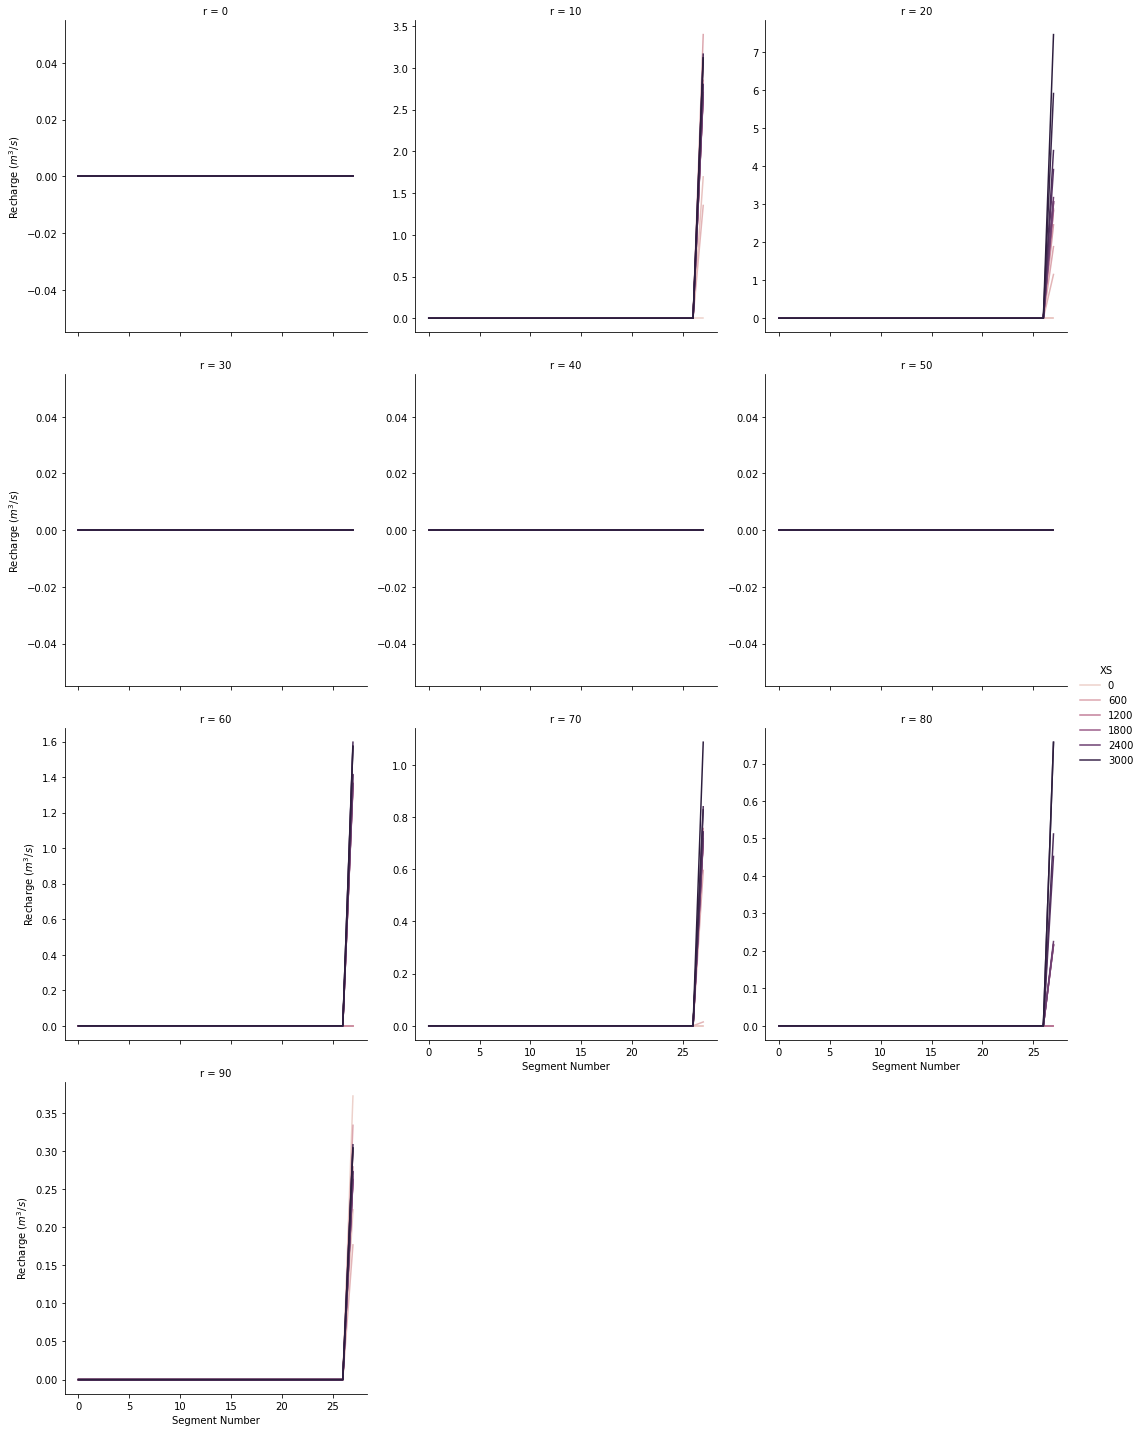

In [404]:
import seaborn as sns
# not sure why only a few colors appear in the legend
ax = sns.relplot(
    data=xs_sum_long[xs_sum_long.r.isin(np.arange(0,100,10))],
    x="nseg", y="rch_m_s",
    hue="XS", hue_order = setbacks,  col = 'r', col_wrap=3,
#     height=4, aspect=.7, 
    facet_kws={'sharey': False, 'sharex': True},
    kind="line"
)
ax.set_ylabels('Recharge ($m^3/s$)')
ax.set_xlabels('Segment Number')

## Streamflow data
Routing flow down channel: original intent was to focus on a few sizes of streamflows based on return periods (e.g., 5, 20 years) but I could run this every day with variable streamflow for the past 10 years to identify the number of days when floodplains are activated. The next level would be to run this with inundation maps for everyday.

Need to start with singular flow events to test the difficulty of running iterative flow with leakage dependent on flood depth and number of high flow cells. It's easy to think the work would be more interesting if everything was in a complex model but often the simpler more fundamental work is what is meaningful therefore I should work for parsimony by testing a singular flow and using a Darcy recharge before going more complex.

In [70]:
# Cosumnes River at Michigan Bar, daily flow cfs
# from 10/1/1983 to 10/1/2010
# inflow_15 = pd.read_csv('data\MI_bar_15min.csv', parse_dates = True, 
#                 index_col = 0, sep = ',', header = 'infer')

## Groundwater level data

## Muskingum Parameters 

K is the travel time for the river and $N_{steps}$ is the number of sub reaches so that the total travel time adds to K  
Value of X ranges from 0 for reservoir-type storage to 0.5 for a full wedge. When X = 0 there is no wedge so no backwater (e.g., level-pool reservoir). **In natural stream X is between 0 and 0.3 with a mean near 0.2.** Great accuracy is not needed due to insensitivity.  
US ACE (1990) criterion for number of routing reaches:
$$ \frac{1}{2(1-X)} \leq \frac{K}{N_{steps}\Delta t} \leq \frac{1}{2X} $$

In [35]:
# actual length of XS
L_XS = 62
# reaches every 1 km
L = 45 # kilomters
K = 13.2*(L_XS/L) # hourly

X = 0.1 # weighting between wedge and pool storage, 0 is pool, 0.5 for a full wedge
l = 1/(2*(1-X))
r = 1/(2*X)
N = 62 # reaches of 1 km
delt = 0.5 # hourly
m = K/(N*delt)

print(l,'<=',m,'<=',r)
# K = K/N # travel time for a reach of length total length/ number of reaches
# print('Max reach storage (ft^3/min):', Smax/K) # (ft^3/min)


0.5555555555555556 <= 0.5866666666666666 <= 5.0


With the given travel time for the lower Cosumnes River with 1 km length reaches requires 0.5 hourly steps and X = 0.1  
x is in the downstream longitudinal channel direction and y (stage) is in the vertical direction away from the streambed.  
Celerity equation:  
$$ c_k = \frac{dx}{dt} = \frac{dQ}{dA} = \frac{1}{B}\frac{dQ}{dy} $$

Muskingum Cunge
Variation of kinematic wave. Cunge (1969) showed when K and del t are constant it is an approximate solution of the kinematic wave. It can be considered an approxmiation of the a modified diffusion equation if 
$$ K = \frac{ \Delta X}{ c_k}  = \frac{\Delta X}{(dQ / dA )}  $$
OR $$ \Delta x = \frac{K}{c_k} $$
$$X = \frac{1}{2}(1-(\frac{Q}{B c_k S_o\Delta X)}  $$

Froude Number, V = flow velocity, surface wave speed =  sqrt(g*y), g = gravity, y= depth:
$$ Fr = \frac{V}{\sqrt{gy} }$$
$$ Fr<1.0 subcritical flow $$ $$ Fr = 1.0 critical flow $$ $$Fr> 1.0 supercritical flow $$

In [ ]:
# froude number <1 subcritical, 1 citical, >1 super critical
# V = flow velocity, surface wave speed =  sqrt(g*y), g = gravity, y= depth
# Fr = V/npsqrt(9.81*y)

Text(0, 0.5, 'Celerity')

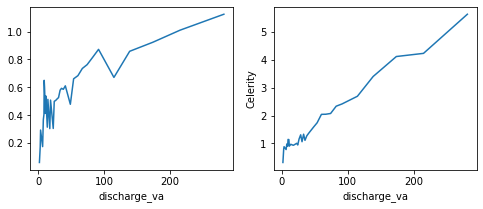

In [76]:
sfr_dir = gwfm_dir+'/SFR_data/'
# discharge is m3/day
mb = pd.read_csv(sfr_dir+ 'michigan_bar_icalc4_data.csv')
mb.discharge_va /= 86400

mb_diff = mb.diff(axis=0)
mb['ck'] = mb_diff.discharge_va/(mb_diff.gage_height_va * mb.chan_width )
mb['delX'] = K/mb.ck
mb['Fr'] = mb.discharge_va/(mb.gage_height_va *mb.chan_width)/ np.sqrt(mb_diff.gage_height_va * 9.80665 )

fig,axes=plt.subplots(1,2, figsize=(8,3))
mb.plot(x = 'discharge_va',y='Fr', label='Fr',legend=False, ax=axes[0])
ax.set_ylabel('Froude Number')
mb.plot(x = 'discharge_va',y='ck',  label='ck',legend=False, ax=axes[1])
axes[1].set_ylabel('Celerity')


In [119]:
def Muskingum(I, N, K, X):
    T = len(I)
    # N rows and T columns
    dim = [N+1, T]
    dim2 = [N, T]
    Q = np.zeros(dim)
    S = np.zeros(dim2)
    mb = np.zeros(dim2)
    e = np.zeros(dim2)
    
    Q[0,:] = I # set first row as historic inflow
    Q[1:,0] = Q[0,0] # assume initial inflow equals outflow all reaches
    S[:,0] = K*Q[1,0] # assume initial storage equals outflow because no wedge storage
    
    # Muskingum coefficients
    C1 = (delt - 2*K*X)/(2*K*(1-X)+delt)
    C2 = (delt + 2*K*X)/(2*K*(1-X)+delt)
    C3 = (2*K*(1-X)-delt)/(2*K*(1-X)+delt)
#     print('C1:', C1,'C2:', C2, 'C3:', C3)
    
    for j in range(0,T-1):
        for i in np.arange(0, N):
            Q[i+1,j+1] = np.clip(C1*Q[i,j+1] + C2*Q[i,j] + C3*Q[i+1,j], 0, 1E15)
            
    return(Q)

## Muskingum Routing

## Distance and then time calculations

In [184]:
def Adj_Muskingum(I, N, K, X, k, gwe, elev):
    T = len(I)
    # N rows and T columns
    dim = [N+1, T]
    dim2 = [N, T]
    Q = np.zeros(dim)
    S = np.zeros(dim2)
    mb = np.zeros(dim2)
    e = np.zeros(dim2)
    swe = np.zeros(dim2)
    dh = np.zeros(dim2)
    qA = np.zeros(dim2)
    
    Q[0,:] = I # set first row as historic inflow
    Q[1:,0] = Q[0,0] # assume initial inflow equals outflow all reaches
    S[:,0] = K*Q[1,0] # assume initial storage equals outflow because no wedge storage
    
    # Muskingum coefficients
    C1 = (delt - 2*K*X)/(2*K*(1-X)+delt)
    C2 = (delt + 2*K*X)/(2*K*(1-X)+delt)
    C3 = (2*K*(1-X)-delt)/(2*K*(1-X)+delt)
#     print('C1:', C1,'C2:', C2, 'C3:', C3)
    
    for j in range(0,T-1):
        # replace linear interpolation with Manning equation with XS data
        swe[:, j] = np.linspace(TWC_stage(Q[-1,j]), MB_stage(Q[0,j]), 48)+elev
        # update to allow for gw disconnection
        dh[:, j] =  (swe[:,j] - gwe)/(elev - gwe)
        for i in np.arange(0, N):
            # groundwater seepage term
            q = k[i]*dh[i,j] # darcian groundwater flow
            qA[i,j] = q*perimeter_base*rchlen # volumetric groundwater seepage
            Q[i+1,j+1] = np.clip(C1*Q[i,j+1] + C2*Q[i,j] + C3*Q[i+1,j] - qA[i,j], 0, 1E15)
            
            S[i,j+1] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j]))
            
#         if current storage is greater than max
#             if S[i,j] > Smax:
#                 # calculate the excess storage
#                 e[i,j] = S[i,j] - Smax
#                 # remove the excess storage from the outflow because it
#                 # is considered overbank flow
#                 Q[i,j] = Q[i,j] - e[i,j]/(K*(1-X))
#                 # reduce storage by amount that went overbank
#                 S[i,j] = S[i,j] - e[i,j]
                
            # mass balance check
            mb[i,j] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j])) - S[i,j+1]
#         swe[:, j+1] = np.linspace(TWC_stage(Q[i+1,j+1]), MB_stage(Q[i+1,j+1]), 48)
#         dh[:, j+1] =  swe[:,j+1] - gwe[:,j+1]
    return(Q, S, e, mb)

In [185]:
# Flow statistics 
def stat(x):
    print('Min:', np.min(x), 'Max:', np.max(x), 'Mean:', np.mean(x))

# 15 minute discharge

In [186]:
# Run of adjusted Muskingum routing which gives outflow for all reaches

I = inflow_15_reg.Discharge_cfs.values
# need to convert to cfm from cfs
I0 = I*60

t1 = datetime.now()
tQ, tS, e, mb = Adj_Muskingum(I0, N, K, X, krch, gwe, elev)
t2 =  datetime.now()
print(t2-t1)



0:07:27.300214


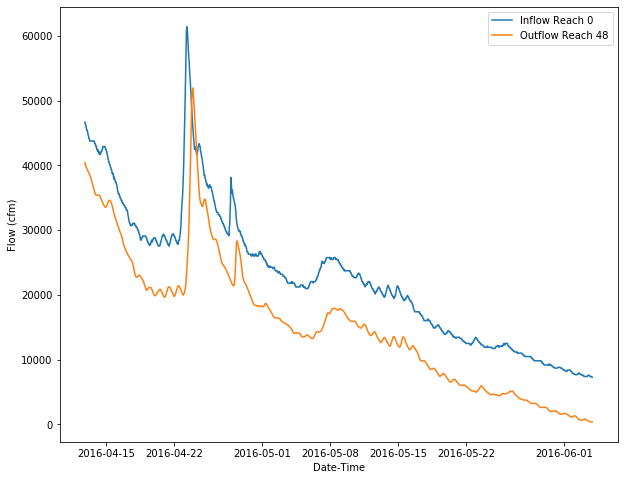

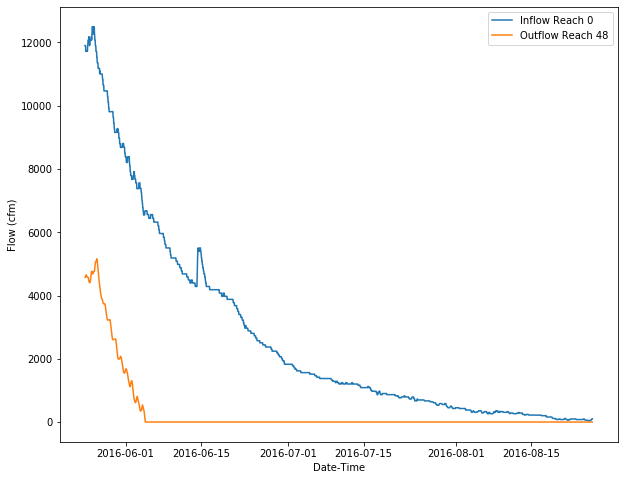

In [187]:
r = 47 # between 0 and 47
# between 0 and 200,000
outflow = pd.DataFrame(index = inflow_15_reg.index, data = np.transpose(tQ))
dt = np.arange(194000,199000)
plt.figure(figsize = (10,8))
plt.plot(outflow[1][dt])
plt.plot(outflow[48][dt])
plt.xlabel('Date-Time')
plt.ylabel('Flow (cfm)')
plt.legend(['Inflow Reach 0', 'Outflow Reach 48'])
plt.savefig('Routed_inflow_outflow_peaks', dpi = 300, bbox = 8)


## Longitudinal plotting of streamflow

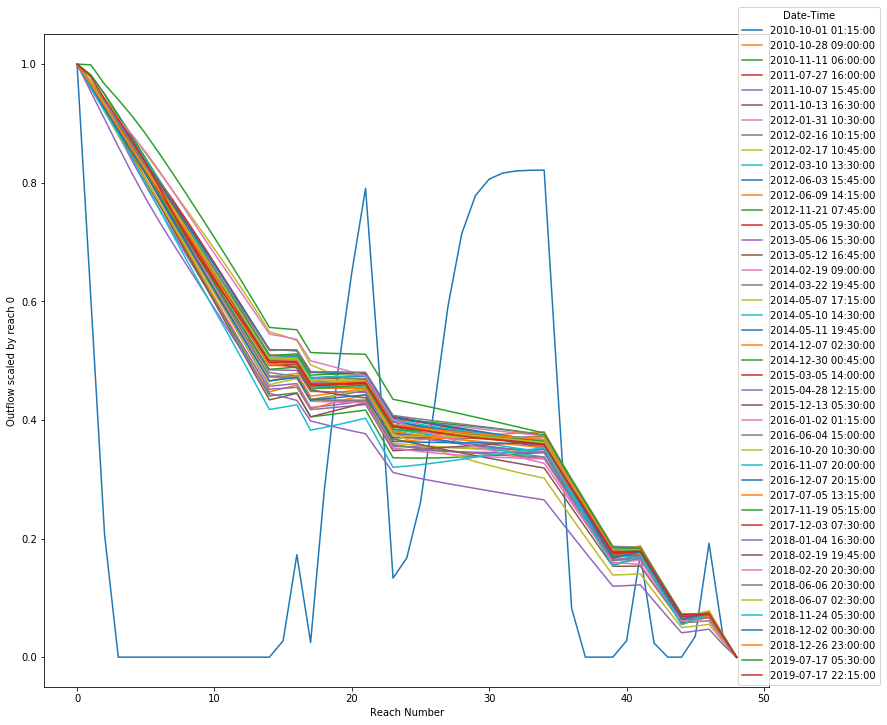

In [196]:
# time where the flow in the last reach was 0
l0 = np.where(tQ[48] ==0)[0]
# set first index
keep0 = l0[0]
# filter out for only the first time when flow = 0
for i in np.arange(1,len(l0)):
    if l0[i]-l0[i-1] == 1:
        keep0 = keep0
    else:
        keep0 = np.append(keep0, l0[i])

# initial time of historic data
t1 = inflow_15_reg.index[0]
# time when outflow at rch 48 went to 0
keep0_dt = t1 + keep0*timedelta(minutes=15)

# start date is 10/1/2011, end is 10/1/2017??
plt.figure(figsize = (13,12))
for t in keep0:
    plt.plot(tQ[:,t]/tQ[0,t])
    # plt.plot(tQ[t], '*')
    # plt.plot(tQ[0,t], 'x')

lgd = plt.legend( labels = keep0_dt, title = 'Date-Time', bbox_to_anchor=(.95, 1.05))
plt.xlabel('Reach Number')
plt.ylabel('Outflow scaled by reach 0')
# plt.show()
plt.savefig('time_flow_0', bbox_extra_artists=(lgd))



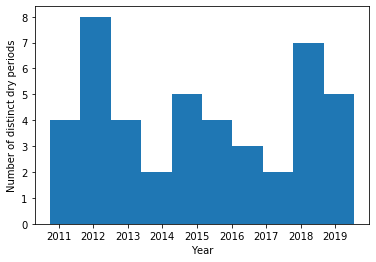

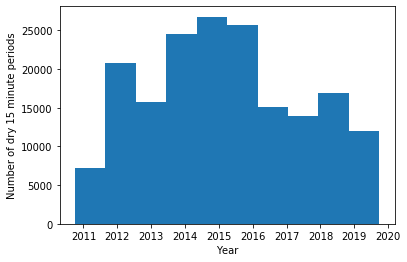

In [212]:
# Histogram plotting of drying time
# time where the flow in the last reach was 0
l0 = np.where(tQ[48] ==0)[0]
# set first index
all0 = l0
keep0 = l0[0]

# filter out for only the first time when flow = 0
for i in np.arange(1,len(l0)):
    if l0[i]-l0[i-1] == 1:
        keep0 = keep0
    else:
        keep0 = np.append(keep0, l0[i])

# initial time of historic data
t1 = inflow_15_reg.index[0]
# time when outflow at rch 48 went to 0
keep0_dt = t1 + keep0*timedelta(minutes=15)

# keep_df = pd.DataFrame(index = keep0_dt, data = keep0_dt)
# dryday = keep_df.resample('AS-Oct')
# plt.hist(dryday)
plt.hist(keep0_dt, bins = 10)
plt.ylabel('Number of distinct dry periods')
plt.xlabel('Year')
# plt.show()
plt.savefig('histogram_dryperiods_', dpi = 300, bbox = 8)
plt.show()
# convert to datetime
all0_dt = t1 + all0*timedelta(minutes=15)

# number of dry 15 minute periods
plt.hist(all0_dt, bins = 10)

# lgd = plt.legend( labels = keep0_dt, title = 'Date-Time', bbox_to_anchor=(1.05, 1.05))
plt.xlabel('Year')
plt.ylabel('Number of dry 15 minute periods')
# plt.show()
plt.savefig('histogram_flow_0', dpi = 300, bbox = 8)


dryQ = tQ[:,all0]

In [224]:
# Find the time difference between discharge being zero in the last, middle and  first reach
# 
# time where the flow in the last reach was 0
def zero_flow(rchn):
    l0 = np.where(tQ[rchn] ==0)[0]
    # set first index
    keep0 = l0[0]
    # filter out for only the first time when flow = 0
    for i in np.arange(1,len(l0)):
        if l0[i]-l0[i-1] == 1:
            keep0 = keep0
        else:
            keep0 = np.append(keep0, l0[i])

    # initial time of historic data
    t1 = inflow_15_reg.index[0]
    # time when outflow at rch 48 went to 0
    keep0_dt = t1 + keep0*timedelta(minutes=15)
    return keep0_dt

rch0 = zero_flow(0)
rch24 = zero_flow(24)
rch48 = zero_flow(48)

res0 = np.zeros(len(rch0))
res24 = np.zeros(len(rch24))

for i in range(0,len(rch0)):
    res0[i] = np.argmin(np.abs(rch0[i]-rch24))
    
for i in range(0,len(rch24)):
    res24[i] = np.argmin(np.abs(rch24[i]-rch48))

# rch24.iloc[rch24.index.get_loc(rch0 ,method='nearest')]
print(res0)
print(res24)



[17. 17. 17. 17. 17. 17. 24.]
[ 0.  1.  2.  3.  3.  4.  5.  5. 11. 12. 12. 15. 15. 15. 16. 16. 20. 20.
 21. 22. 23. 23. 24. 24. 24. 25. 25. 27. 27. 28. 29. 29. 31. 32. 34. 38.
 39. 40. 41. 43. 43. 43. 43.]


(array([ 0,  1,  2,  4,  5,  7,  8, 10, 13, 15, 17, 18, 19, 21, 24, 26, 28,
       29, 31, 32, 35, 36, 37, 38, 42], dtype=int64),)
                           0
2010-10-01 01:15:00     0.75
2010-10-28 09:00:00    67.75
2010-11-11 06:00:00      171
2011-07-27 16:00:00   425.25
2011-10-07 15:45:00    38.25
2011-10-13 16:30:00   978.25
2012-06-09 14:15:00      247
2012-11-21 07:45:00     95.5
2013-05-12 16:45:00  1108.75
2014-02-19 09:00:00    165.5
2014-05-11 19:45:00   287.75
2014-12-07 02:30:00    25.25
2014-12-30 00:45:00   184.25
2015-03-05 14:00:00   508.25
2015-04-28 12:15:00   403.75
2015-12-13 05:30:00    83.75
2016-06-04 15:00:00    358.5
2016-10-20 10:30:00    27.25
2016-11-07 20:00:00      265
2017-07-05 13:15:00    332.5
2018-06-07 02:30:00      430
2018-11-24 05:30:00    22.25
2018-12-02 00:30:00   110.25
2018-12-26 23:00:00      116
2019-07-17 22:15:00    381.5


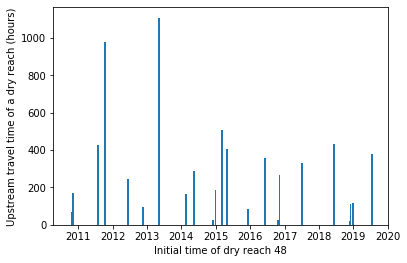

In [348]:

rch48_m = rch48[res24.astype(int)]
diff = rch24 - rch48_m

x = np.c_[rch24, rch48_m]

for i in range(1,len(x)):
    if x[i,0] < x[i,1]:
        x[i,0] = False
    elif x[i,1] == x[i-1,1]:
        x[i-1] = False

l1 = np.where(x[:,0]!=False)
print(l1)
x = x[l1,:]
diff = x[0][:,0] - x[0][:,1]
for i in range(0,len(diff)):
    diff[i] = diff[i].total_seconds()/3600 
# durations = [datetime.timedelta(hours=h+30).total_seconds()/3600.0 for h in it]
# print(x[0][:,1])
df = pd.DataFrame(index = x[0][:,1], data = diff)
print(df)
plt.bar(df.index, height = diff, width = 20)
plt.ylabel('Upstream travel time of a dry reach (hours)')
plt.xlabel('Initial time of dry reach 48')
# plt.savefig('traveltime_48_to_24_0', dpi = 300, bbox = 8)


## Summary Statistics of routed streamflow

In [192]:
print('Inflow')
stat(tQ[0,:])
print('Outflow')
stat(tQ[1:,:])
print('Storage')
stat(tS) # mean 540,000 and max = 59 million
# estimated max reach storage is 10 million which seems reasonable based on historic data

Inflow
Min: 0.0 Max: 2982000.0 Mean: 34196.64903491802
Outflow
Min: 0.0 Max: 2961875.6654253798 Mean: 30897.22388073167
Storage
Min: -1.1761227458606527e-07 Max: 51735259.3159553 Mean: 541074.0398010531


Look at propagating the uncertainty through from the regression to the rest of the calculations. Only using 4 years of data at LWC is okay for the project as long as I discuss it, but it probably wouldn't fly for a real paper. 